# 3. Gyakorlat: Politika iteráció

In [149]:
import numpy as np
import matplotlib.pyplot as plt

## Környezet definiálása
A környezet egy 3 állapotos Markov döntési folyamat, sűrű jutalmakkal. Minden állapotból lehetséges eljutni az összes többibe, ezáltal egy jóval nagyobb cselekvési teret kell az ügynöknek megtanulnia. 

In [150]:
class Environment():
    def __init__(self):
        self.p_s_a = [  # Állapotátmeneti valószínűségek (környezeti dinamika) [s, a, s']
            [[0.7, 0.3, 0.0],   # s0 --> a0 --> [s0, s1, s2]
             [1.0, 0.0, 0.0],   # s0 --> a1 --> [s0, s1, s2]
             [0.8, 0.2, 0.0]],  # s0 --> a2 --> [s0, s1, s2]
            [[0.0, 1.0, 0.0],   # s1 --> a0 --> [s0, s1, s2]
             [0.3, 0.1, 0.6],   # s1 --> a1 --> [s0, s1, s2]
             [0.0, 0.0, 1.0]],  # s1 --> a2 --> [s0, s1, s2]
            [[0.1, 0.9, 0.0],   # s2 --> a0 --> [s0, s1, s2]
             [0.8, 0.1, 0.1],   # s2 --> a1 --> [s0, s1, s2]
             [0.7, 0.0, 0.3]]   # s2 --> a2 --> [s0, s1, s2]
        ]

        self.R = [              # Jutalmak [s, a, s']
            [[10, 0, 0],        # s0 --> a0 --> [r0, r1, r2]
             [0, 0, 4],         # s0 --> a1 --> [r0, r1, r2]
             [0, -1, 0]],       # s0 --> a2 --> [r0, r1, r2]
            [[12, 0, 0],        # s1 --> a0 --> [r0, r1, r2]
             [10, 0, -2],       # s1 --> a1 --> [r0, r1, r2]
             [0, 0, -50]],      # s1 --> a2 --> [r0, r1, r2]
            [[-20, 0, 1],       # s2 --> a0 --> [r0, r1, r2]
             [40, 0, 0],        # s2 --> a1 --> [r0, r1, r2]
             [0, 0, 20]],       # s2 --> a2 --> [r0, r1, r2]
        ]

        self.A = [              # Lehetséges cselekvések halmaza
            [0, 1, 2],          # s0 --> s0, s1, s2
            [0, 1, 2],          # s1 --> s0, s2
            [0, 1, 2]           # s2 --> s1
        ]

        self.s0 = 0
        self.s = self.s0
        self.n_s = len(self.p_s_a)  # Állapotok száma
        self.n_a = max([len(x) for x in self.A])  # Cselekvések száma

    def reset(self):
        self.s = self.s0

    def step(self, s, a):
        sp = np.random.choice(range(self.n_s), p=self.p_s_a[s][a])
        r = self.R[s][a][sp]
        return r, sp

## Politika kiértékelése

<img src=policy-evaluation.png alt="Politika kiértékelése" width="900">

In [151]:
def policy_evaluation(env, policy, V, gamma, tol):
    while True:
        delta = 0  # Változás mértéke
        for s in range(env.n_s):
            if env.A[s] is None:
                continue
            v = V[s]
            V[s] = sum(env.p_s_a[s][policy[s]][sp] * (env.R[s][policy[s]][sp] + gamma * V[sp]) for sp in env.A[s])  # V(s) kiszámítása
            delta = max(delta, abs(v - V[s]))

        if delta < tol:  # Ha a változás kisebb mint a küszöb, az algoritmus konvergált
            break
        
    return V

## Politika javítása

<img src=policy-improvement.png alt="Politika javítása" width="900">

In [152]:
def policy_improvement(env, policy, V, gamma):
    policy_stable = True
    for s in range(env.n_s):
        if env.A[s] is None:
            continue
        
        old_action = policy[s]
        policy[s] = np.argmax([sum(env.p_s_a[s][a][sp] * (env.R[s][a][sp] + gamma * V[sp]) for sp in range(env.n_s)) for a in env.A[s]])  # Optimális cselekvés

        if old_action != policy[s]:  # Ha van változás a politikában, a politika instabil
            policy_stable = False

    return policy

## Iteratív kiértékelés-javítás

In [153]:
def policy_iteration(env, gamma=0.9, tol=1e-6):
    # Initialize policy and value function
    V_hist = []
    V = np.zeros(env.n_s)
    V_old = np.zeros(env.n_s)
    policy = np.zeros(env.n_s, dtype=int)

    i = 0    
    while True:
        V = policy_evaluation(env, policy, V, gamma, tol)  # Politika kiértékelése
        new_policy = policy_improvement(env, policy, V, gamma)  # Politika javítása
        
        policy = new_policy
        i += 1
        if np.sum(np.abs(V_old - V)) < tol:
            print(f'Konvergált {i} iteráicó alatt')
            break
        
        V_hist.append(V_old)
        V_old = V.copy()
    
    return policy, V, V_hist

In [154]:
env = Environment()
optimal_policy, optimal_value, V_hist = policy_iteration(env)
print("Optimális politika:", optimal_policy)
print("Optimális értékfüggvény:", optimal_value)

Konvergált 10 iteráicó alatt
Optimális politika: [0 1 1]
Optimális értékfüggvény: [ 90.21656469  97.70418231 116.20802523]


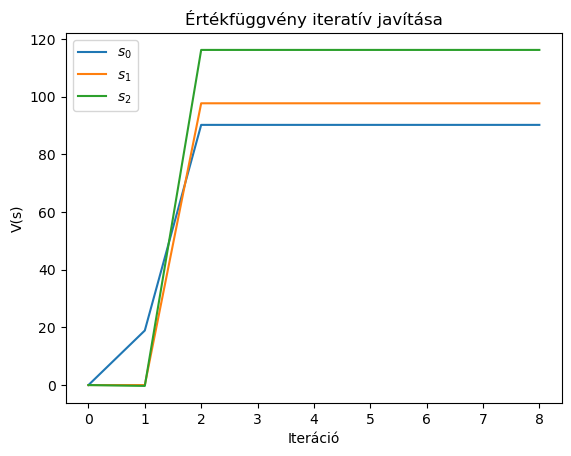

In [155]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(V_hist)), V_hist, linestyle='-', label=['$s_0$', '$s_1$', '$s_2$'])
ax.set_xlabel('Iteráció')
ax.set_ylabel('V(s)')
ax.set_title('Értékfüggvény iteratív javítása')
ax.legend()
plt.show()
